In [9]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

In [10]:
from torch.nn.functional import linear
from torch.optim import SGD
model = nn.Linear(10, 1)
optimizer = SGD(model.parameters(), lr=1e-3)
optimizer.param_groups[0]

{'params': [Parameter containing:
  tensor([[ 0.2274,  0.2186,  0.2930, -0.2337, -0.1990,  0.0083, -0.0324,  0.1789,
            0.1493, -0.2852]], requires_grad=True),
  Parameter containing:
  tensor([-0.1051], requires_grad=True)],
 'lr': 0.001,
 'momentum': 0,
 'dampening': 0,
 'weight_decay': 0,
 'nesterov': False,
 'maximize': False,
 'foreach': None,
 'differentiable': False,
 'fused': None}

# 🔍 `optimizer.param_groups[0]` 详解笔记

在 PyTorch 中，优化器 `optimizer` 会将所有待优化的参数划分为一个或多个 **参数组（parameter groups）**，每个组是一个字典（`dict`），用于指定：

- 哪些参数属于该组（键名为 `'params'`）
- 该组的学习率（`'lr'`）、动量（`'momentum'`）等超参数

---

## ✨ 示例代码

```python
import torch
import torch.nn as nn
from torch.nn.functional import linear
from torch.optim import SGD

# 定义一个线性模型
model = nn.Linear(10, 1)

# 初始化优化器
optimizer = SGD(model.parameters(), lr=1e-3)

# 查看第一个参数组的内容
param_group = optimizer.param_groups[0]
print(param_group)
```

---

## 📌 `param_groups[0]` 包含哪些内容？

输出内容类似如下（因权重地址不同略有不同）：

```python
{
 'params': [Parameter containing: ...],
 'lr': 0.001,
 'momentum': 0,
 'dampening': 0,
 'weight_decay': 0,
 'nesterov': False,
 'maximize': False,
 'foreach': None,
 'differentiable': False
}
```

---

## 🔧 自定义多个参数组（不同学习率）

```python
optimizer = SGD([
	{'params': model.layer1.parameters(), 'lr': 1e-3},
	{'params': model.layer2.parameters(), 'lr': 1e-4}
])
```

这样可以为模型的不同部分设定不同的学习率。

---

## ✅ 总结一句话：

> `optimizer.param_groups[0]` 是一个字典，描述优化器中第一个参数组的参数和超参数设置，可用于调试或动态修改优化器行为。

# 📌 Rosenbrock 函数

Rosenbrock 函数，也被称为“香蕉函数”，是优化算法中常用的非凸测试函数。

---

## 📐 数学表达式

二维 Rosenbrock 函数定义如下：

$$
f(x, y) = (a - x)^2 + b(y - x^2)^2
$$

其中：

- $ a = 1 $
- $ b = 100 $（常用设定）

带入参数后的标准形式为：

$$
f(x, y) = (1 - x)^2 + 100(y - x^2)^2
$$

---

## ✅ 最小值

- **最小值点**：$ (x, y) = (1, 1) $
- **函数值**：$ f(1, 1) = 0 $

---

## 📈 函数特性

- 非凸，具有弯曲的狭谷，难以优化
- 常用于测试梯度下降等优化算法的性能
- 对初始值敏感，梯度下降可能陷入局部最优

---

## 🧪 可视化建议

用 `matplotlib` 绘制等高线图或三维图可以直观理解其优化路径特性。

---

## 🔧 Python 示例

```python
def rosenbrock(x, y, a=1, b=100):
	return (a - x)**2 + b * (y - x**2)**2
```

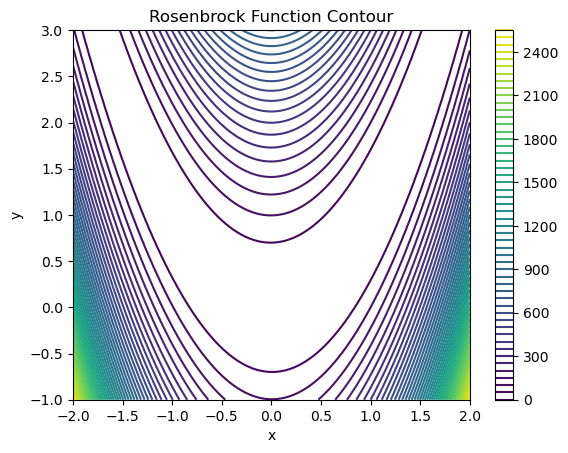

In [11]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x, y)

Z = (1 - X)**2 + 100 * (Y - X**2)**2  # Rosenbrock 函数

plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.title("Rosenbrock Function Contour")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [12]:
class SimpleModel(nn.Module):
	def __init__(self):
		super().__init__()
		self.params = nn.Parameter(torch.tensor([-2.0,1.0]))

	def forward(self):
		x, y = self.params[0], self.params[1]
		return (1 - x)**2 + 100 * (y - x**2)**2

In [13]:
# Initial model and state
from copy import deepcopy
base_model = SimpleModel()
initial_state = deepcopy(base_model.state_dict())


In [14]:
def run_optimizer(optimizer_class, lr, steps=5000):
	model = SimpleModel()
	model.load_state_dict(deepcopy(initial_state))
	optimizer = optimizer_class(model.parameters(), lr=lr)
	trace, losses = [], []

	for _ in range(steps):
		optimizer.zero_grad()
		loss = model()
		loss.backward()
		optimizer.step()
		with torch.no_grad():
			trace.append(model.params.clone().numpy())
			losses.append(loss.item())
	return np.array(trace), losses

In [15]:
from torch import optim
optimizers = {
	# "SGD": (optim.SGD, 1e-3),
	"Adam": (optim.Adam, 1e-1),
	"Adagrad": (optim.Adagrad, 1e-1),
	"RMSprop": (optim.RMSprop, 1e-1),
	"Adadelta": (optim.Adadelta, 1e-1), # Adadelta 不依赖初始学习率，1.0 是推荐值
	"Adamw": (optim.AdamW, 1e-1)
}

results = {}
for name, (opt_class, lr) in optimizers.items():
	trace, losses = run_optimizer(opt_class, lr)
	results[name] = {"trace": trace, "losses": losses}


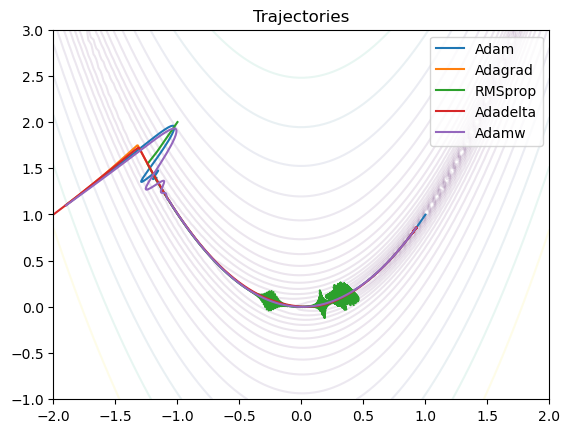

In [16]:
plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), alpha=0.1)
for name, res in results.items():
	plt.plot(res["trace"][:, 0], res["trace"][:, 1], label=name)
plt.title("Trajectories")
plt.legend()
plt.show()

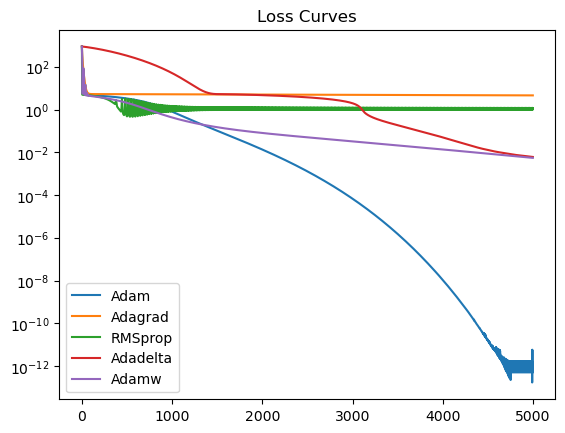

In [17]:
plt.figure()
for name, res in results.items():
	plt.plot(res["losses"], label=name)
plt.yscale("log")
plt.title("Loss Curves")
plt.legend()
plt.show()